 # 31. ML 모델링 with feature engineering

 변수를 추가해 봅시다.

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

## (3) 데이터 불러오기

In [5]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBike_Simple.csv'
bike = pd.read_csv(path)
bike['Datetime'] = pd.to_datetime(bike['Datetime'] )
bike.rename(columns={'Rented Bike Count':'Count'}, inplace = True)
bike = bike.loc[bike['Datetime'].between('2018-06-11','2018-08-13', inclusive = 'left'),
                      ['Datetime', 'Temperature', 'Humidity','Count']]
bike.reset_index(drop = True, inplace = True)

In [6]:
bike

,Datetime,Temperature,Humidity,Count
0,2018-06-11 00:00:00,20.3,58.0,918
1,2018-06-11 01:00:00,19.8,59.0,555
2,2018-06-11 02:00:00,19.2,60.0,353
3,2018-06-11 03:00:00,18.8,61.0,232
4,2018-06-11 04:00:00,18.8,60.0,194
...,...,...,...,...
1507,2018-08-12 19:00:00,32.0,76.0,1117
1508,2018-08-12 20:00:00,29.4,86.0,1208
1509,2018-08-12 21:00:00,28.9,83.0,1337
1510,2018-08-12 22:00:00,28.8,79.0,1127


## (4) 데이터 둘러보기

In [7]:
bike.describe(include = 'all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Datetime,1512,1512,2018-06-11,1,2018-06-11,2018-08-12 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,1509.0,NaN,NaT,NaN,NaT,NaT,26.983764,4.75233,16.3,23.2,27.1,30.4,39.4
Humidity,1509.0,NaN,NaT,NaN,NaT,NaT,66.153744,16.860646,23.0,53.0,66.0,80.0,98.0
Count,1512.0,NaN,NaT,NaN,NaT,NaT,1036.53836,685.269919,9.0,543.5,909.0,1426.25,3556.0


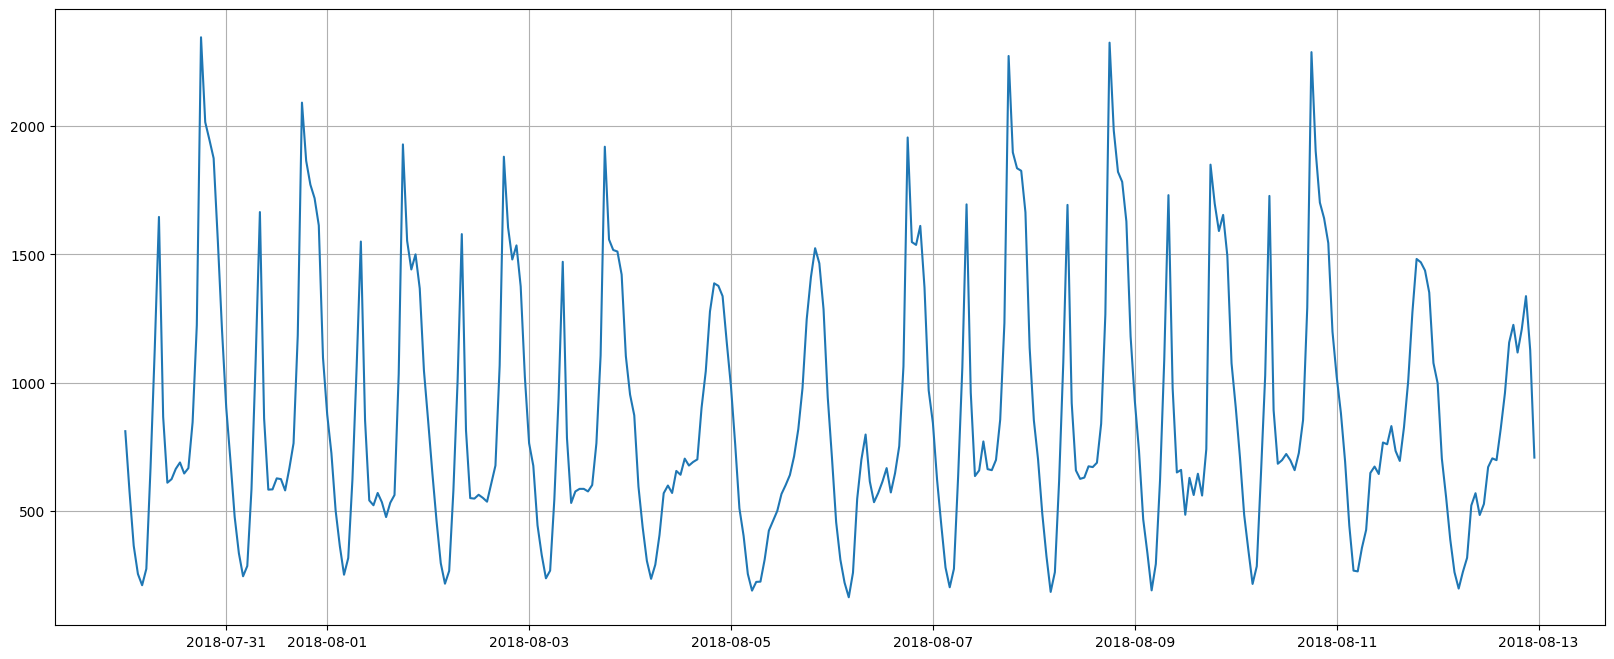

In [8]:
# 마지막 14일의 그래프를 그려 봅시다.
size = 24 * 14
temp = bike.iloc[-size:]
plt.figure(figsize = (20,8))
plt.plot('Datetime', 'Count', data = temp)
plt.grid()
plt.show()

# 2.전처리

## (1) y 만들기

In [9]:
data = bike.copy()

In [10]:
data['y'] = data['Count'].shift(-2)

In [11]:
data = data.iloc[:-2]

## (2) NaN 조치

In [12]:
data.fillna(method = 'ffill', inplace = True)

## (3) Feature Engineering

### 1) 날짜 요소 뽑기

| 메서드 | 내용|
|----|----|
df['date'].dt.date         		| YYYY-MM-DD(문자)
df['date'].dt.year         		| 연(4자리숫자)
df['date'].dt.month        		| 월(숫자)
df['date'].dt.month_name()		| 월(문자)
df['date'].dt.day          		| 일(숫자)
df['date'].dt.time         		| HH:MM:SS(문자)
df['date'].dt.hour         		| 시(숫자)
df['date'].dt.minute       		| 분(숫자)
df['date'].dt.second       		| 초(숫자)
df['date'].dt.quarter       		| 분기(숫자)
df['date'].dt.day_name()  	| 요일이름(문자)
df['date'].dt.weekday       		| 요일숫자(0-월, 1-화) (=dayofweek)
df['date'].dt.weekofyear    		| 연 기준 몇주째(숫자) (=week)
df['date'].dt.dayofyear     		| 연 기준 몇일째(숫자)
df['date'].dt.days_in_month 	| 월 일수(숫자) (=daysinmonth)



In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     1510 non-null   datetime64[ns]
 1   Temperature  1510 non-null   float64       
 2   Humidity     1510 non-null   float64       
 3   Count        1510 non-null   int64         
 4   y            1510 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 59.1 KB


#### ① 요일 --> 주말여부
* 먼저 요일을 뽑고,
* 주말 여부로 변환

In [14]:
data['Datetime'].dt.weekday

0       0
1       0
2       0
3       0
4       0
       ..
1505    6
1506    6
1507    6
1508    6
1509    6
Name: Datetime, Length: 1510, dtype: int64

In [15]:
np.where(data['Datetime'].dt.weekday < 5, 0, 1)

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
data['weekend'] = np.where(data['Datetime'].dt.weekday < 5, 0, 1)
data.head()

,Datetime,Temperature,Humidity,Count,y,weekend
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0


#### ② 활동시간 구분
* 시간을 추출하고, 다음과 같이 범주로 생성합니다.
    * 0 : 활동 없음, 1 : 일상 활동시간, 2 : 출퇴근
    * 0~6 : 0
    * 7~8 : 2
    * 9~16: 1
    * 17~20 : 2
    * 21~23 : 0


In [17]:
data['Active'] = pd.cut(data['Datetime'].dt.hour, bins=[0,6,8,16,20,23], labels = [0,2,1,2,0],
                        ordered = False, include_lowest = True)

### 2) 시간의 흐름을 feature로 담기

#### ① shift

In [18]:
temp = data[['Datetime', 'y']].copy()
temp.head()

,Datetime,y
0,2018-06-11 00:00:00,353.0
1,2018-06-11 01:00:00,232.0
2,2018-06-11 02:00:00,194.0
3,2018-06-11 03:00:00,324.0
4,2018-06-11 04:00:00,807.0


In [19]:
# shift(1)
temp['lag1'] = temp['y'].shift()

# shift(2)
temp['lag2'] = temp['y'].shift(2)

# shift(-1)
temp['lag_1'] = temp['y'].shift(-1)
temp.head()

,Datetime,y,lag1,lag2,lag_1
0,2018-06-11 00:00:00,353.0,NaN,NaN,232.0
1,2018-06-11 01:00:00,232.0,353.0,NaN,194.0
2,2018-06-11 02:00:00,194.0,232.0,353.0,324.0
3,2018-06-11 03:00:00,324.0,194.0,232.0,807.0
4,2018-06-11 04:00:00,807.0,324.0,194.0,1629.0


* 24시간 전 수요량

In [20]:
data['lag24'] = data['y'].shift(24)
data.head(30)

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0,0,NaN
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0,0,NaN
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,0,0,NaN
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,0,0,NaN
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,0,2,NaN
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,0,2,NaN
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,0,1,NaN


#### ② rolling

In [21]:
temp = data[['Datetime', 'y']].copy()
temp.head()

,Datetime,y
0,2018-06-11 00:00:00,353.0
1,2018-06-11 01:00:00,232.0
2,2018-06-11 02:00:00,194.0
3,2018-06-11 03:00:00,324.0
4,2018-06-11 04:00:00,807.0


In [22]:
# 3일 이동평균
temp['MA3'] = temp['y'].rolling(3).mean()

# 3일 이동최대값
temp['MM3'] = temp['y'].rolling(3).max()

# 3일 이동평균(min_period = 1)
temp['MA3_1'] = temp['y'].rolling(3, min_periods=1).mean()

temp.head()

,Datetime,y,MA3,MM3,MA3_1
0,2018-06-11 00:00:00,353.0,NaN,NaN,353.000000
1,2018-06-11 01:00:00,232.0,NaN,NaN,292.500000
2,2018-06-11 02:00:00,194.0,259.666667,353.0,259.666667
3,2018-06-11 03:00:00,324.0,250.000000,324.0,250.000000
4,2018-06-11 04:00:00,807.0,441.666667,807.0,441.666667


* 4시간 이동평균

In [23]:
data['MA4'] = data['Count'].rolling(4, min_periods = 1).mean()
data.head(10)

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN,918.000000
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN,736.500000
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN,608.666667
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0,0,NaN,514.500000
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0,0,NaN,333.500000
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,0,0,NaN,275.750000
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,0,0,NaN,389.250000
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,0,2,NaN,738.500000
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,0,2,NaN,1283.750000
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,0,1,NaN,1529.500000


#### ③ diff
특정 시점 대비 증감

In [24]:
temp = data[['Datetime', 'y']].copy()
temp.head()

,Datetime,y
0,2018-06-11 00:00:00,353.0
1,2018-06-11 01:00:00,232.0
2,2018-06-11 02:00:00,194.0
3,2018-06-11 03:00:00,324.0
4,2018-06-11 04:00:00,807.0


In [25]:
# 전일대비 증감
temp['Diff1'] = temp['y'].diff()

# 2일 전 대비 증가
temp['Diff2'] = temp['y'].diff(2)

temp.head()

,Datetime,y,Diff1,Diff2
0,2018-06-11 00:00:00,353.0,NaN,NaN
1,2018-06-11 01:00:00,232.0,-121.0,NaN
2,2018-06-11 02:00:00,194.0,-38.0,-159.0
3,2018-06-11 03:00:00,324.0,130.0,92.0
4,2018-06-11 04:00:00,807.0,483.0,613.0


* 전 시간 대비 증감

In [26]:
data['Diff1'] = data['Count'].diff()

* 24시간 전 대비 증감

In [28]:
data['Diff24'] = data['Count'].diff(24)

data.head(30)

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN,918.000000,NaN,NaN
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN,736.500000,-363.0,NaN
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN,608.666667,-202.0,NaN
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0,0,NaN,514.500000,-121.0,NaN
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0,0,NaN,333.500000,-38.0,NaN
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,0,0,NaN,275.750000,130.0,NaN
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,0,0,NaN,389.250000,483.0,NaN
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,0,2,NaN,738.500000,822.0,NaN
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,0,2,NaN,1283.750000,746.0,NaN
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,0,1,NaN,1529.500000,-1068.0,NaN


### 3) decompose

* 시계열 데이터 분해는,
    * 시계열 데이터 안에 있는 반복 추세와 반복 패턴을 찾아내는 과정입니다.
    * 찾아낸 패턴을 하나의 모델로 볼 수도 있습니다.
    * 여기서는 과거의 패턴을 하나의 feature로 도출해 보겠습니다.

#### ① 시계열 데이터를 분해해 봅시다.
* freq 를 조절하며 계절성(seasonal)을 도출해 봅시다.
* 그래프는 위에서 만든 decomp_plot 을 사용합니다.

* 1일(24시간)의 계절성 고려

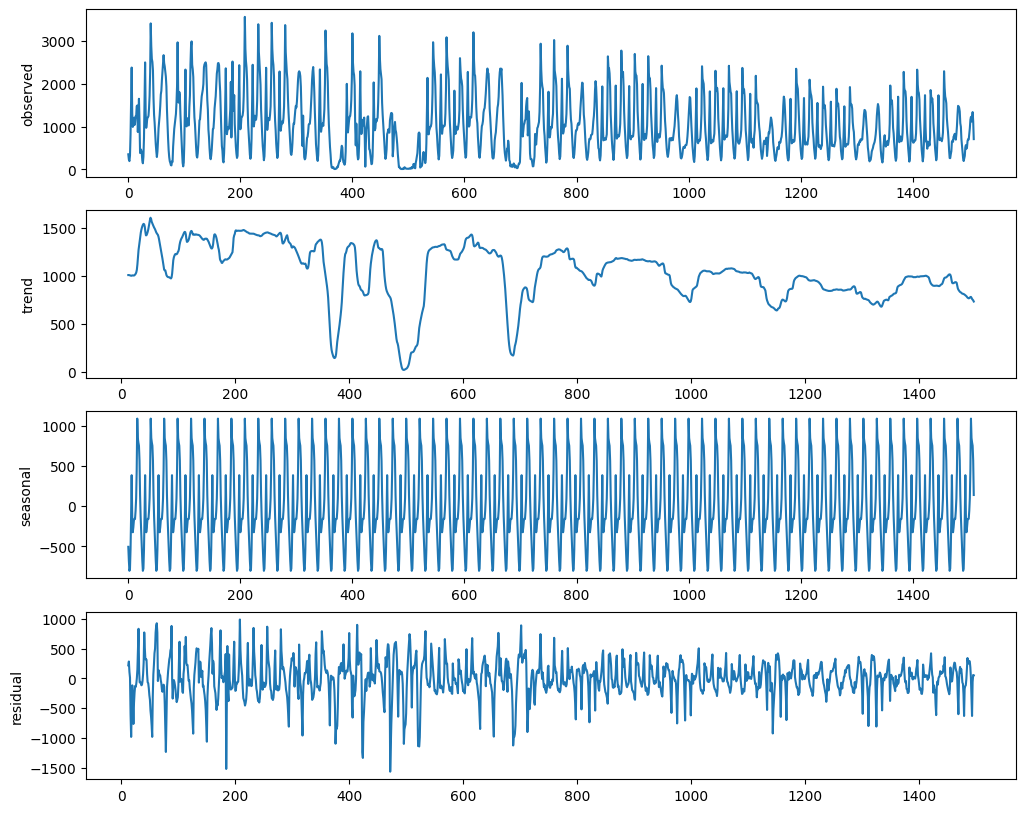

In [29]:
decomp = sm.tsa.seasonal_decompose(data['y'], model = 'additive', period = 24)
plt.figure(figsize=(12,10))
result = decomp_plot(decomp)

* 1주일(7일 * 24시간)의 계절성 고려

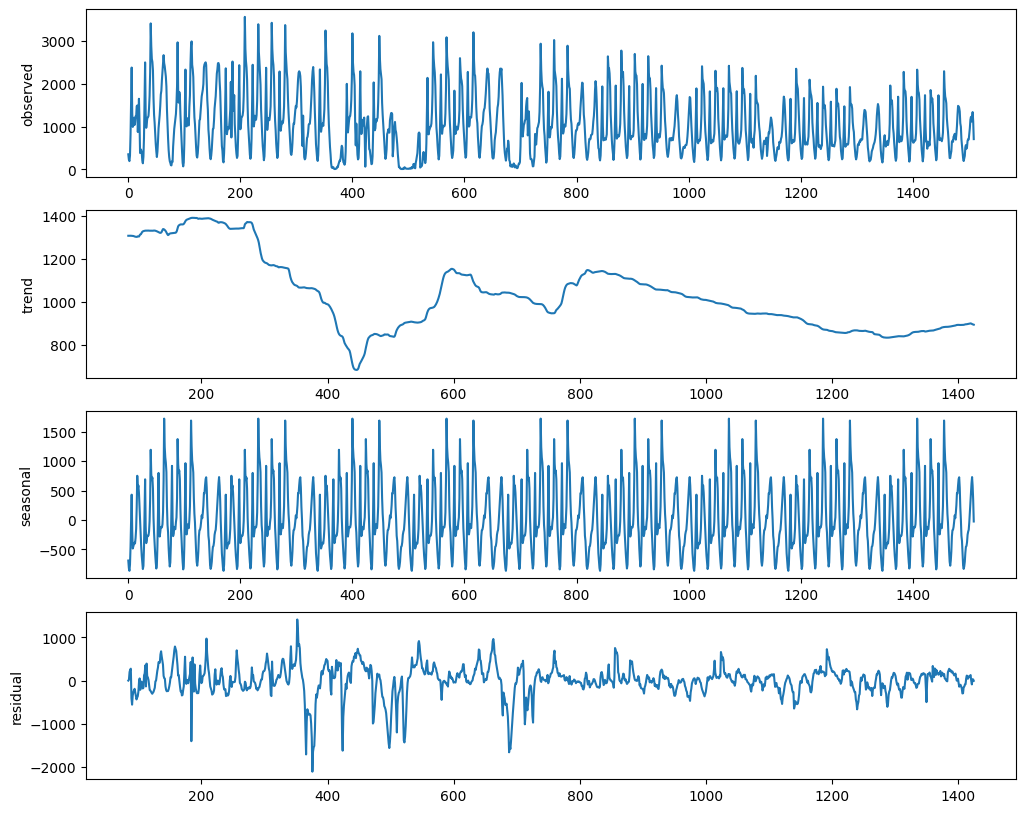

In [30]:
decomp = sm.tsa.seasonal_decompose(data['y'], model = 'additive', period = 7*24)
plt.figure(figsize=(12,10))
result = decomp_plot(decomp)

In [ ]:
result.head()

#### ② seasonal 데이터를 New Feature로 추가합시다.
* 단, train 데이터만을 이용해서 생성한 후 전체에 입력해야 합니다.
* val size : 24 * 14 이므로 이 데이터를 빼고 나머지만 가지고 시계열 데이터 분할

* seasonal 패턴1 저장
    * period = 24 이므로, seasonal 패턴은 24시간 주기

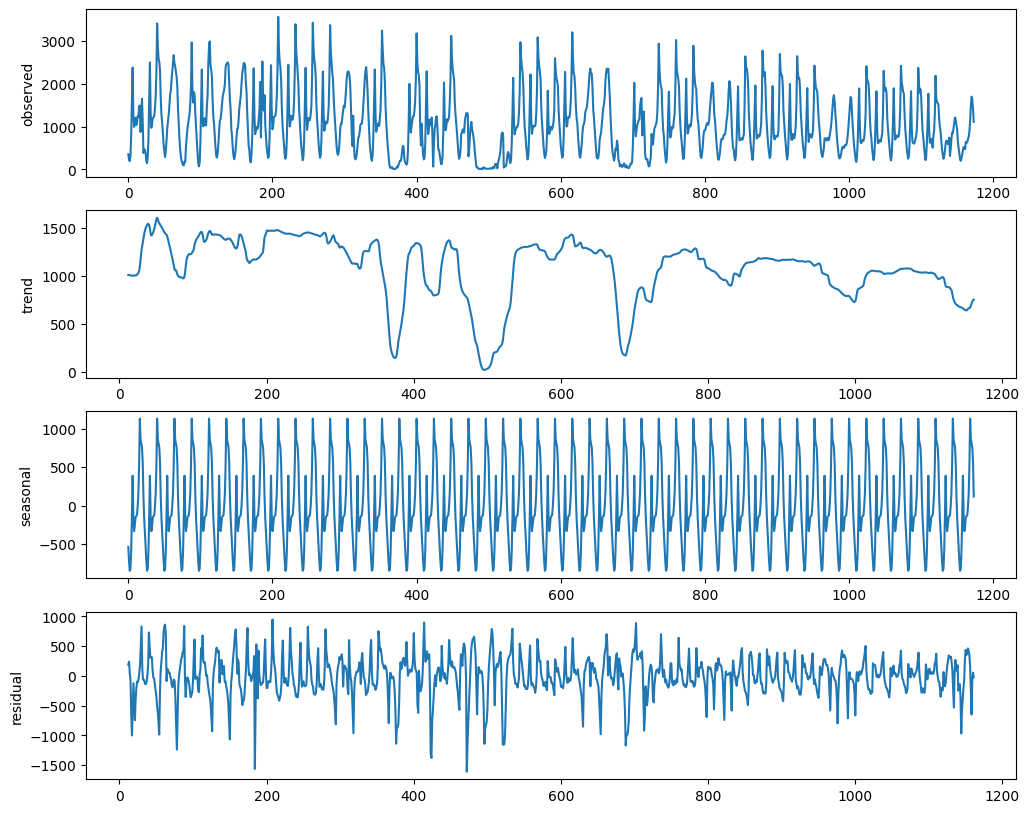

In [31]:
val_size = 24 * 14
decomp = sm.tsa.seasonal_decompose(data.y[:-val_size], model = 'additive', period = 24)
plt.figure(figsize=(12,10))
result = decomp_plot(decomp)

In [32]:
display(data.head(3))
display(data.iloc[24:27])

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN,918.000000,NaN,NaN
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN,736.500000,-363.0,NaN
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN,608.666667,-202.0,NaN


,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24
24,2018-06-12 00:00:00,18.0,94.0,470,385.0,0,0,353.0,904.50,86.0,-448.0
25,2018-06-12 01:00:00,17.7,92.0,454,206.0,0,0,232.0,606.25,-16.0,-101.0
26,2018-06-12 02:00:00,17.7,87.0,385,144.0,0,0,194.0,423.25,-69.0,32.0


In [33]:
display(result.head(3))
display(result.iloc[24:27])

,observed,trend,seasonal,residual
0,353.0,NaN,-538.479131,NaN
1,232.0,NaN,-718.890590,NaN
2,194.0,NaN,-849.274704,NaN


,observed,trend,seasonal,residual
24,385.0,1018.645833,-538.479131,-95.166702
25,206.0,1026.104167,-718.890590,-101.213577
26,144.0,1040.291667,-849.274704,-47.016962


In [34]:
data.iloc[-val_size:]

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24
1174,2018-07-29 22:00:00,30.4,45.0,1406,810.0,1,0,921.0,1556.75,-232.0,248.0
1175,2018-07-29 23:00:00,29.9,45.0,1108,575.0,1,0,636.0,1462.25,-298.0,69.0
1176,2018-07-30 00:00:00,29.2,50.0,810,363.0,0,0,511.0,1240.50,-298.0,-111.0
1177,2018-07-30 01:00:00,28.5,54.0,575,253.0,0,0,403.0,974.75,-235.0,-61.0
1178,2018-07-30 02:00:00,28.0,57.0,363,209.0,0,0,245.0,714.00,-212.0,-148.0
...,...,...,...,...,...,...,...,...,...,...,...
1505,2018-08-12 17:00:00,33.7,48.0,1156,1117.0,1,2,1482.0,908.00,197.0,150.0
1506,2018-08-12 18:00:00,33.4,49.0,1225,1208.0,1,2,1469.0,1040.00,69.0,-49.0
1507,2018-08-12 19:00:00,32.0,76.0,1117,1337.0,1,2,1437.0,1114.25,-108.0,-365.0
1508,2018-08-12 20:00:00,29.4,86.0,1208,1127.0,1,2,1351.0,1176.50,91.0,-261.0


In [35]:
# 24개 주기 seasonal 데이터 붙이기
seasonal24 = result.seasonal[:24]

# 전체 데이터 건수 만큼 Seasonal 데이터 만들기
n = data.shape[0] // 24 + 1
seasonal_all = list(seasonal24) * n
seasonal_all[: data.shape[0]]

# data 셋에 붙이기
data['Seasonal24'] = seasonal_all[: data.shape[0]]
data.head(10)

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24,Seasonal24
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN,918.000000,NaN,NaN,-538.479131
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN,736.500000,-363.0,NaN,-718.890590
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN,608.666667,-202.0,NaN,-849.274704
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0,0,NaN,514.500000,-121.0,NaN,-822.281649
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0,0,NaN,333.500000,-38.0,NaN,-587.253003
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,0,0,NaN,275.750000,130.0,NaN,-142.658819
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,0,0,NaN,389.250000,483.0,NaN,389.456633
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,0,2,NaN,738.500000,822.0,NaN,-136.803784
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,0,2,NaN,1283.750000,746.0,NaN,-332.362812
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,0,1,NaN,1529.500000,-1068.0,NaN,-262.198315


* seasonal 패턴2 저장
    * period = 7 * 24

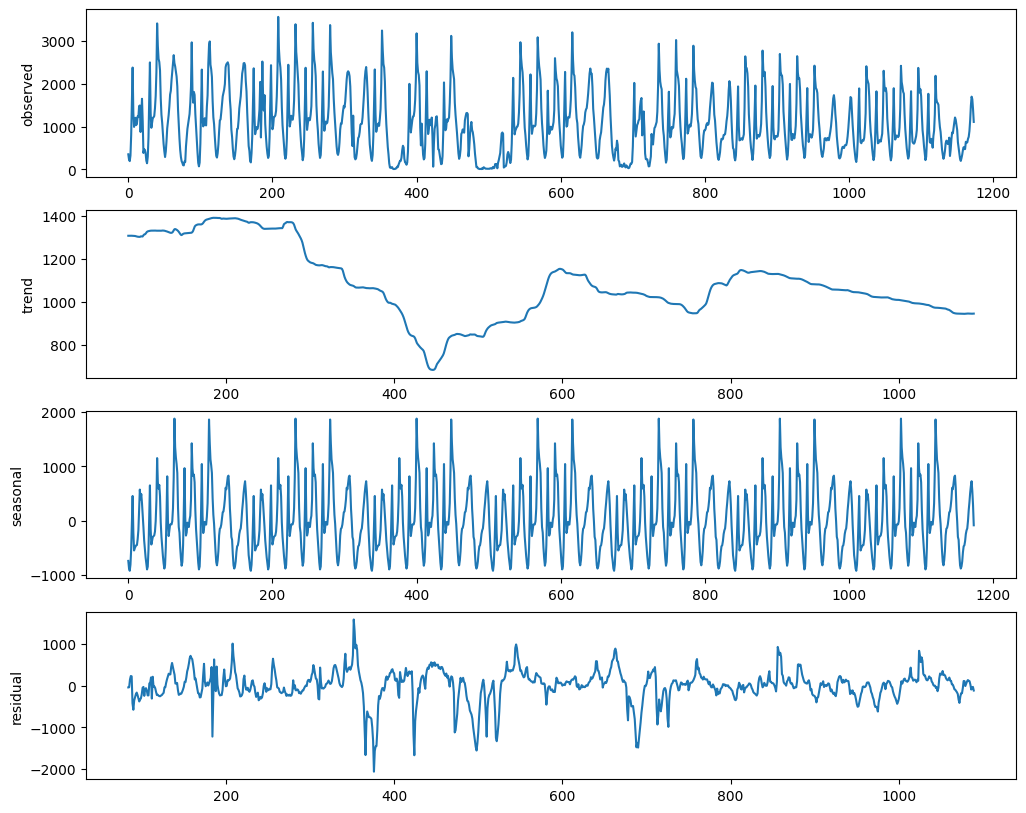

In [36]:
val_size = 24 * 14
decomp = sm.tsa.seasonal_decompose(data.y[:-val_size], model = 'additive', period = 24*7)
plt.figure(figsize=(12,10))
result = decomp_plot(decomp)

In [37]:
# 24 * 7개 주기 seasonal 데이터 붙이기
seasonal168 = result.seasonal[:24 * 7]

# 전체 데이터 건수 만큼 Seasonal 데이터 만들기
n = data.shape[0] // 168 + 1
seasonal_all = list(seasonal168) * n
seasonal_all[: data.shape[0]]

# data 셋에 붙이기
data['Seasonal168'] = seasonal_all[: data.shape[0]]
data.head(10)

,Datetime,Temperature,Humidity,Count,y,weekend,Active,lag24,MA4,Diff1,Diff24,Seasonal24,Seasonal168
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,0,0,NaN,918.000000,NaN,NaN,-538.479131,-741.407593
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,0,0,NaN,736.500000,-363.0,NaN,-718.890590,-878.762256
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,0,0,NaN,608.666667,-202.0,NaN,-849.274704,-924.192811
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,0,0,NaN,514.500000,-121.0,NaN,-822.281649,-811.612454
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,0,0,NaN,333.500000,-38.0,NaN,-587.253003,-517.549458
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,0,0,NaN,275.750000,130.0,NaN,-142.658819,-29.489438
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,0,0,NaN,389.250000,483.0,NaN,389.456633,455.993201
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,0,2,NaN,738.500000,822.0,NaN,-136.803784,-215.485966
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,0,2,NaN,1283.750000,746.0,NaN,-332.362812,-548.835668
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,0,1,NaN,1529.500000,-1068.0,NaN,-262.198315,-504.977533


## (4) NaN 추가 조치

In [38]:
data.isna().sum()

Datetime        0
Temperature     0
Humidity        0
Count           0
y               0
weekend         0
Active          0
lag24          24
MA4             0
Diff1           1
Diff24         24
Seasonal24      0
Seasonal168     0
dtype: int64

* 여기서 NaN은 삭제합시다.

In [39]:
data1 = data.dropna(axis = 0)
data1.reset_index(drop = True, inplace = True)

## (5) 가변수화

In [41]:
# 요일 변수를 가변수화
data2 = pd.get_dummies(data1, columns = ['Active'], drop_first = True )
data2.head()

,Datetime,Temperature,Humidity,Count,y,weekend,lag24,MA4,Diff1,Diff24,Seasonal24,Seasonal168,Active_1,Active_2
0,2018-06-12 00:00:00,18.0,94.0,470,385.0,0,353.0,904.50,86.0,-448.0,-538.479131,-677.133287,0,0
1,2018-06-12 01:00:00,17.7,92.0,454,206.0,0,232.0,606.25,-16.0,-101.0,-718.890590,-789.535569,0,0
2,2018-06-12 02:00:00,17.7,87.0,385,144.0,0,194.0,423.25,-69.0,32.0,-849.274704,-899.121879,0,0
3,2018-06-12 03:00:00,17.5,87.0,206,296.0,0,324.0,378.75,-179.0,-26.0,-822.281649,-847.300450,0,0
4,2018-06-12 04:00:00,17.5,84.0,144,740.0,0,807.0,297.25,-62.0,-50.0,-587.253003,-535.535073,0,0


## (6) 데이터 분할

### 1) x, y 나누기

* .values(넘파이 어레이)로 변환해서 저장하는 이유 ➡ 데이터 스플릿 index를 적용해서 데이터를 가져오기 위해서

In [42]:
target = 'y'

x = data2.drop([target, 'Datetime'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [43]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

# 3.모델링1 : Linear Regression

## (1) 학습 및 예측

### 1) 학습

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
model1 = LinearRegression()
model1.fit(x_train, y_train)

LinearRegression()

### 2) 예측

In [46]:
# 예측
pred = model1.predict(x_val)

## (3) 평가

### 1) 검증성능

In [47]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 180.38481543542994
MAPE: 0.2451287256525815
R2  : 0.7782664370098162


### 2) 결과 시각화

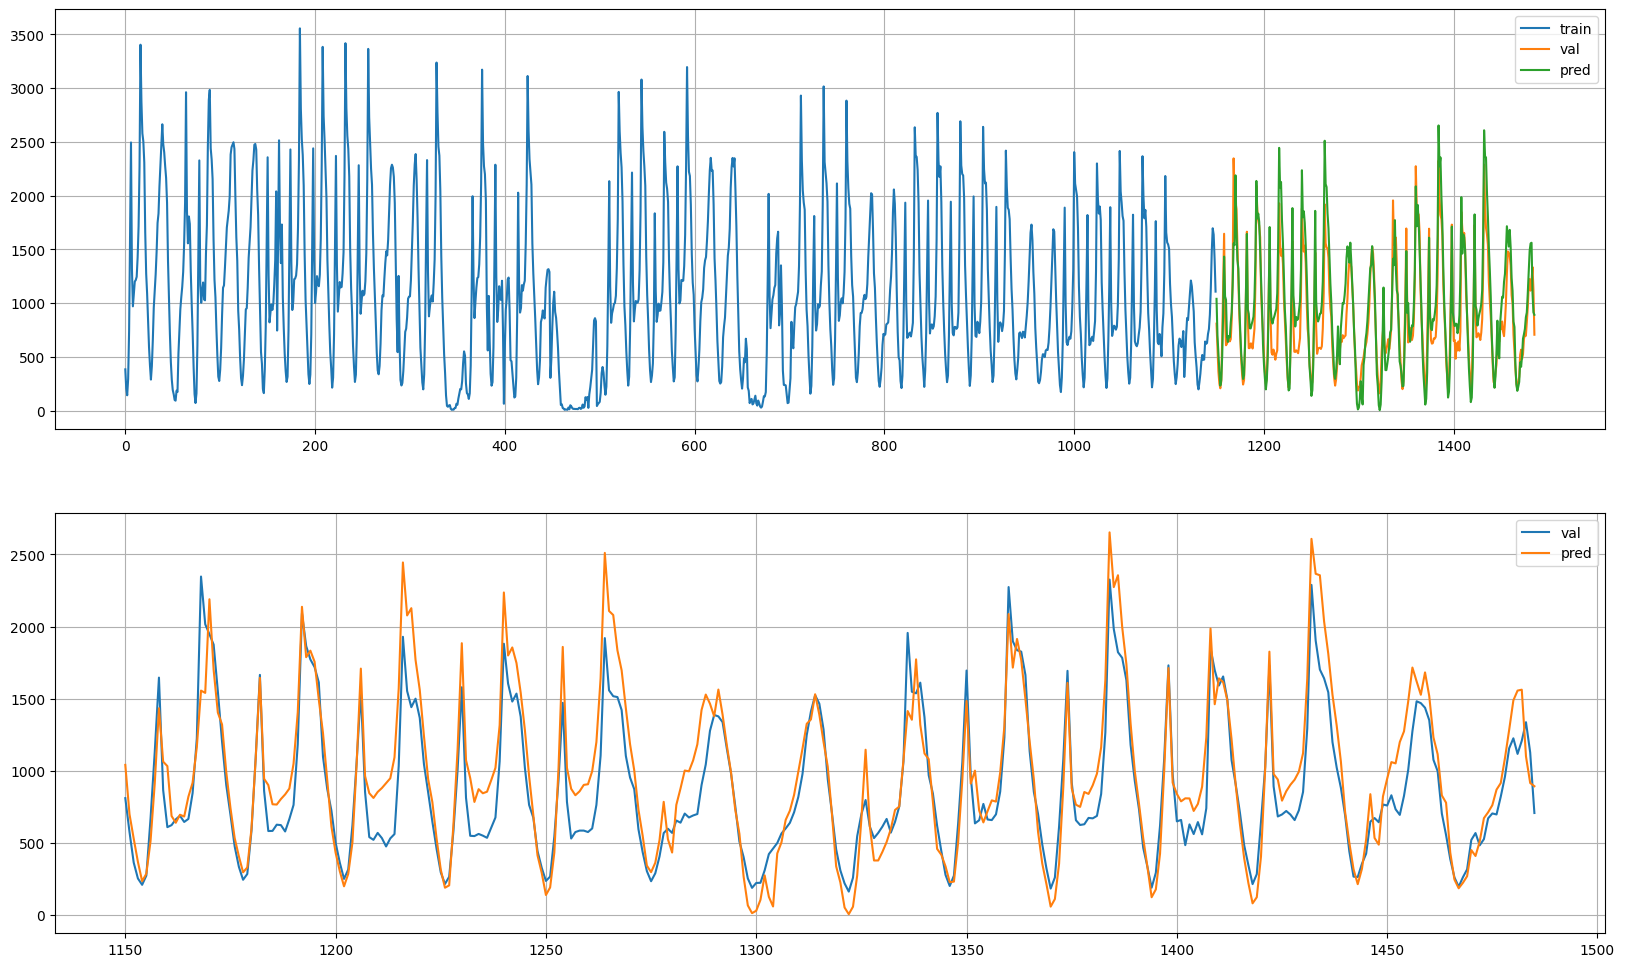

In [48]:
plot_model_result(y_train, y_val, pred)

# 4.모델링2 : XGB

## (1) 학습 및 예측

### 1) 학습

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# 1~2분 소요
# hyper parameter 설정
params = {'n_estimators':range(10, 101, 10), 'learning_rate':np.linspace(0.001, 0.3, 20)}

# Grid Search
model2 = GridSearchCV(XGBRegressor(), params, cv = 3, verbose = 2 )
model2.fit(x_train, y_train)

In [51]:
model2.best_params_

{'learning_rate': 0.04821052631578947, 'n_estimators': 80}

### 2) 예측

In [52]:
# 예측
pred = model2.predict(x_val)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_val - pred

## (3) 평가

### 1) 검증성능

In [53]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 102.30854924519856
MAPE: 0.12020118679470089
R2  : 0.8961871821524481


### 2) 결과 시각화

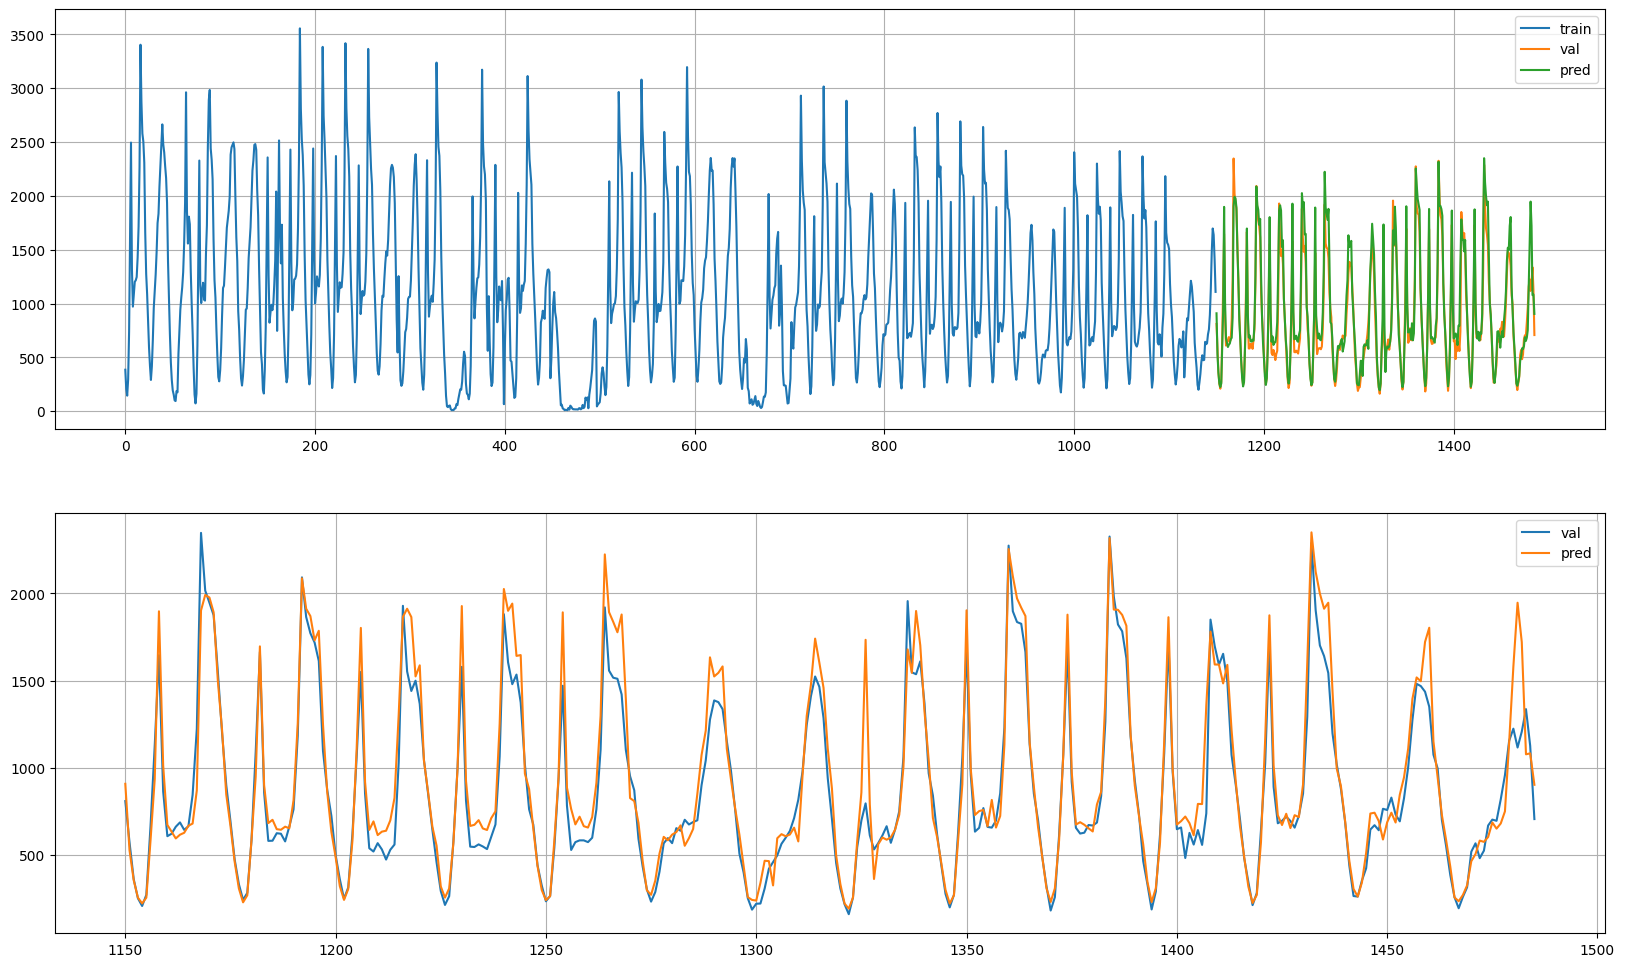

In [54]:
plot_model_result(y_train, y_val, pred)

# 5.전처리 데이터 저장
* joblib을 이용하여 데이터프레임 저장하기

In [55]:
import joblib

joblib.dump(data2, 'data2.pkl')

['data2.pkl']